<a href="https://colab.research.google.com/github/Chirag-creator17/ML/blob/main/binary_class_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Perceptron


In [2]:
import numpy as np
import os
import io
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, make_scorer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# warnings.filterwarnings("ignore")

In [3]:
X,y=fetch_openml('mnist_784',version=1,return_X_y=True)

In [4]:
X=X.to_numpy()
y=y.to_numpy()

In [5]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'Number of features: {X.shape[1]}')
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of samples: 70000, type: float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


#### Data Scaling

In [6]:
X = MinMaxScaler().fit_transform(X)
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')

Minimum: 0.0, Maximum: 1.0


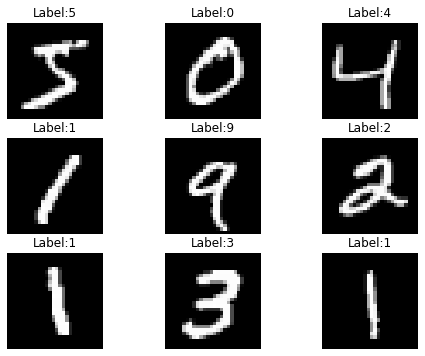

In [26]:
num_images=9
factor=np.int64(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

Label: 5


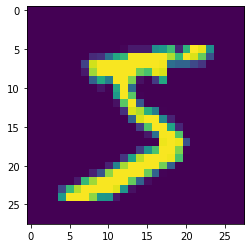

In [27]:
print(f'Label: {y[0]}')
plt.imshow(X[0].reshape(28, 28))

In [12]:
# splitting data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

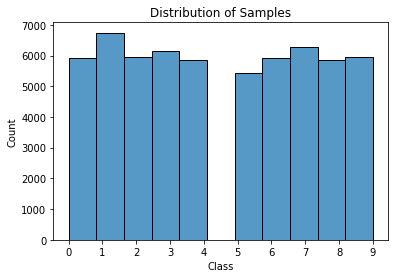

In [13]:
sns.histplot(data=np.int8(y_train), bins=11)
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

#### Binary Classification

In [15]:
#initialize new variable names with all -1
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print(f'Training accuracy: {base_clf.score(X_train, y_train_0):.2f}')
print(f'Testing accuracy: {base_clf.score(X_test, y_test_0):.2f}')

Training accuracy: 0.90
Testing accuracy: 0.90


#### Perceptron Model

In [16]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
bin_clf.fit(X_train, y_train_0)
print(f'Dimension of weights: {bin_clf.coef_.shape}')
print(f'Bias: {bin_clf.intercept_}')
print(f'Loss function: {bin_clf.loss_function_}, loss value: {bin_clf.loss}')

Dimension of weights: (1, 784)
Bias: [-108.]
Loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7f54a5989290>, loss value: perceptron


In [18]:
y_hat_train_0 = bin_clf.predict(X_train)
print(f'Training accuracy is {bin_clf.score(X_train, y_train_0)}')
y_hat_test_0 = bin_clf.predict(X_test)
print(f'Test accuracy is {bin_clf.score(X_test, y_test_0)}')

Training accuracy is 0.99095
Test accuracy is 0.989


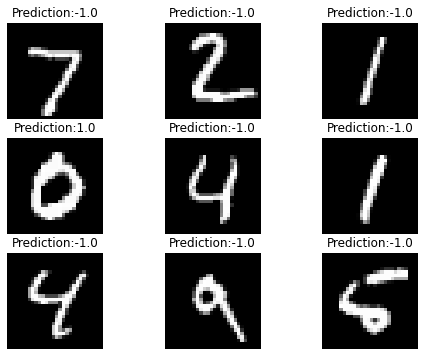

In [28]:
num_images=9
factor=np.int64(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [35]:
#misclassified
indx_0=np.where(y_test_0==1)
zeroLabels=y_hat_test_0[indx_0[0]]
num_misclassified = np.count_nonzero(zeroLabels == -1)
num_correctpred = len(zeroLabels) - num_misclassified
accuracy = num_correctpred / len(zeroLabels)
print(accuracy)

0.9193877551020408


#### confusion matrix

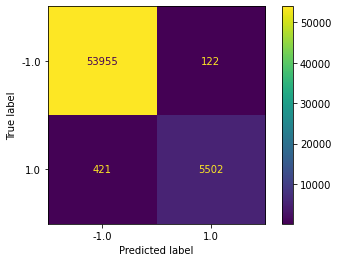

In [33]:
y_hat_train_0 = bin_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [34]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

Precision: 0.9783072546230441, Recall: 0.9289211548201924, Acccuracy: 0.99095


#### Cross validation

In [36]:
bin_cfg = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, X_train, y_train_0, cv=5, scoring=['recall', 'f1', 'precision'], return_estimator=True)
# scores = cross_validate(bin_clf, X_test, y_test_0, cv=5, scoring=['recall', 'f1', 'precision'], return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.99929547, 2.83251476, 2.06154513, 1.61755681, 2.0736618 ]),
 'score_time': array([0.05509758, 0.05776238, 0.04900432, 0.04428339, 0.05315709]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [37]:
print(scores['test_f1'].mean(), scores['test_f1'].std())
print(scores['test_precision'].mean(), scores['test_precision'].std())
print(scores['test_recall'].mean(), scores['test_recall'].std())

0.94205885179654 0.013273174197442695
0.9626569391894069 0.01340770796981747
0.9235106625612953 0.03476545483691418


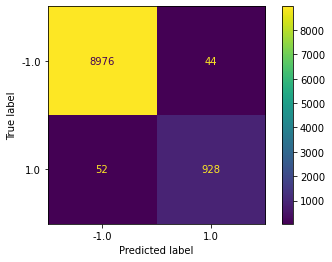

In [38]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')

In [40]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

Precision: 0.9547325102880658, Recall: 0.9469387755102041, Acccuracy: 0.9904


### Another way

Precision: 0.9620119591980303, Recall: 0.9235184872530812, Acccuracy: 0.98885


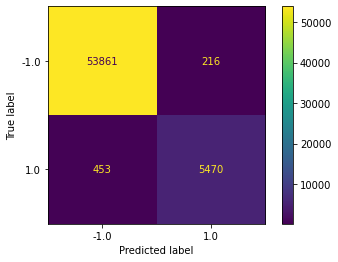

In [41]:
y_hat_train_0 = cross_val_predict(bin_clf, X_train, y_train_0, cv=5)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

In [42]:
print(classification_report(y_train_0, y_hat_train_0))


              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### Precision recall curve

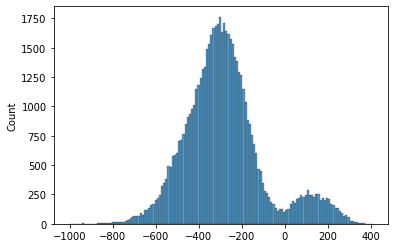

In [43]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(X_train, y_train_0)
y_scores = bin_clf.decision_function(X_train)  #non-linear function h(x)
sns.histplot(np.sort(y_scores))

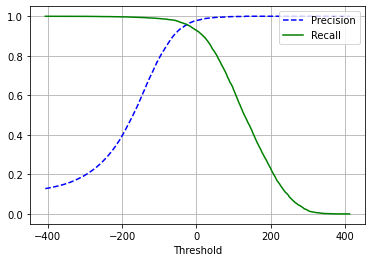

In [44]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
